In [1]:
import matplotlib.pyplot as plt
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import numpy as np
import torch


In [2]:
torch.cuda.set_device(0)
device = torch.device("cuda")
torch.cuda.is_available()


True

In [3]:
df_track_storage = pd.read_json("data/track_storage.jsonl", lines=True)
df_sessions = pd.read_json("data/sessions.jsonl", lines=True)
df_artists = pd.read_json("data/artists.jsonl", lines=True)
df_tracks = pd.read_json("data/tracks.jsonl", lines=True)
df_users = pd.read_json("data/users.jsonl", lines=True)


In [4]:
df = pd.merge(
    df_sessions,
    df_tracks,
    left_on="track_id",
    right_on="id"
).drop(["id"], axis=1)

df = pd.merge(
    df,
    df_artists,
    left_on="id_artist",
    right_on="id"
).drop(["id"], axis=1)

df = df[["timestamp", "genres"]]
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.date  # strftime('%Y-%m')

df.head()


,timestamp,genres
0,2022-04-01,"[neo mellow, piano rock, pop rock, rock]"
1,2022-05-05,"[neo mellow, piano rock, pop rock, rock]"
2,2022-06-13,"[neo mellow, piano rock, pop rock, rock]"
3,2022-06-13,"[neo mellow, piano rock, pop rock, rock]"
4,2022-06-26,"[neo mellow, piano rock, pop rock, rock]"


In [5]:
class Genres:
    def __init__(self) -> None:
        self.genres: list[str] = []
    
    def get(self, x) -> None:
        x = ",".join(x)
        self.genres += x.split(",")
        return x


g = Genres()

df_artists["genres"].apply(lambda x: g.get(x))

popular = {
    "hip hop": [],
    "pop": [],
    "rap": [],
    "rock": [],
    "disco": [],
    "metal": [],
    "punk": [],
    "jazz": [],
    "indie": [],
    "folk": [],
    "r&b": [],
    "soul": [],
    "drill": [],
    "electro": [],
    "house": [],
    "reggae": [],
    "funk": [],
    "dance": [],
    "latin": [],
    "romantic": [],
    "country": [],
    "classical": [],
    "edm": [],
    "_other_": []
    }


for i, e in enumerate(set(g.genres)):
    done = False
    for key in popular.keys():
        if key in e:
            popular[key].append(e)
            done = True
    if not done:
        popular["_other_"].append(e)

ordered_genres = list(set(g.genres))
custom_artists = {}

for key, values in popular.items():
    df[key] = df["genres"].apply(
        lambda x: 1 if set(values).intersection(x) else 0
        )

df = df.drop(["genres"], axis=1)

df = df.groupby([
    'timestamp', 'hip hop', 'pop', 'rap', 'rock', 'disco', 'metal', 'punk', 
    'jazz', 'indie', 'folk', 'r&b', 'soul', 'drill', 'electro', 'house',
    'reggae', 'funk', 'dance', 'latin', 'romantic', 'country', 'classical',
    'edm', '_other_']).size().reset_index(name='count')


print(df.shape)
df.head()


(63687, 26)


,timestamp,hip hop,pop,rap,rock,disco,metal,punk,jazz,indie,...,reggae,funk,dance,latin,romantic,country,classical,edm,_other_,count
0,2022-03-31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,77
1,2022-03-31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1
2,2022-03-31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,16
3,2022-03-31,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,4
4,2022-03-31,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,11


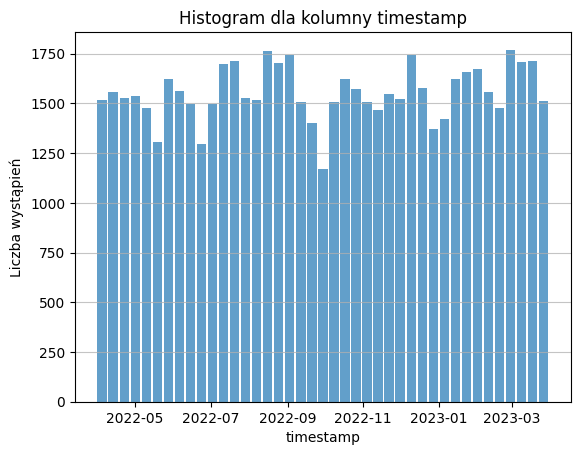

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

column_name = "timestamp"
plt.hist(df[column_name], bins="auto", alpha=0.7, rwidth=0.85)
plt.grid(axis="y", alpha=0.75)
plt.xlabel(column_name)
plt.ylabel("Liczba wystąpień")
plt.title(f"Histogram dla kolumny {column_name}")
plt.show()


In [7]:
mean = df["count"].mean()
std = df["count"].std()
df["count"] = (df["count"] - mean) / std

mean, std


(10.315433290938497, 22.681156415314994)

In [8]:
df = df.sort_values("timestamp")


In [9]:
df.to_csv("./data/prepared.csv", index=False)


In [10]:
def prepare_data(dataset: pd.DataFrame, lookback: int = 7):
    X_series, X_params, y = [], [], []
    for i in range(len(dataset)-lookback):
        x_series = dataset["count"].values.astype('float32')[i:i+lookback]

        x_params = dataset.drop(["count"], axis=1).values.astype('float32')[i:i+lookback]

        target = dataset["count"].values.astype('float32')[i+1:i+lookback+1]

        X_series.append(x_series)
        X_params.append(x_params)
        y.append(target)

    return X_series, X_params, y


X_series, X_params, y = [], [], []

data_batch_size = 500
for i in range(0, len(df), data_batch_size):
    batch = df[i:i+data_batch_size]

    df_track_tmp = batch.drop(["timestamp"], axis=1)
    X_s_tmp, X_p_tmp, y_tmp = prepare_data(df_track_tmp)
    X_series += X_s_tmp
    X_params += X_p_tmp
    y += y_tmp

X_series = torch.tensor(X_series)
X_params = torch.tensor(X_params)
y = torch.tensor(y)


/tmp/ipykernel_20293/396269766.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642969563/work/torch/csrc/utils/tensor_new.cpp:230.)
  X_series = torch.tensor(X_series)


In [11]:
X_series[0], X_params[0], y[0]


(tensor([ 2.9401, -0.4107, -0.2784, -0.2784, -0.3225, -0.2784, -0.4107]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 1.],
         [0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0., 0., 0., 0., 1.],
         [0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 1.],
         [0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 1.],
         [0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
          0., 1., 0., 0., 0., 1.]]),
 tensor([-0.4107, -0.2784, -0.2784, -0.3225, -0.2784, -0.4107, -0.1903]))

In [12]:
train_size = int(len(X_series) * 0.8)
test_size = len(X_series) - train_size

X_s_train, X_s_test = X_series[:train_size], X_series[train_size:]
X_p_train, X_p_test = X_params[:train_size], X_params[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


pd.DataFrame(
    X_s_test.numpy()
    ).to_csv("./data/X_s_test.csv", index=False, header=False)

pd.DataFrame(
    X_p_test.numpy().reshape(-1, X_p_test.shape[-1])
    ).to_csv("./data/X_p_test.csv", index=False, header=False)

pd.DataFrame(
    y_test.numpy()
    ).to_csv("./data/y_test.csv", index=False, header=False)


In [13]:
# df_track_tmp.drop(["count"], axis=1)[0:0+7]
# df_track_tmp["count"][0:0+7]


In [14]:
X_s_train.shape, X_p_train.shape, y_train.shape, "", X_s_test.shape, X_p_test.shape, y_test.shape


(torch.Size([50232, 7]),
 torch.Size([50232, 7, 24]),
 torch.Size([50232, 7]),
 '',
 torch.Size([12559, 7]),
 torch.Size([12559, 7, 24]),
 torch.Size([12559, 7]))

In [15]:
class WeakMusicModel(nn.Module):
    def __init__(self, num_params):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=1, hidden_size=10, num_layers=1, batch_first=True
            )
        self.linear = nn.Linear(10 + num_params, 1).cuda()

    def forward(self, x, params):
        x, (h_n, _) = self.lstm(x)
        return x


num_params = X_p_train.shape[2]
model = WeakMusicModel(num_params).cuda()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()

BATCH_SIZE = 8

train_dataset = data.TensorDataset(X_s_train, X_p_train, y_train)
train_loader = data.DataLoader(
    train_dataset, shuffle=False, batch_size=BATCH_SIZE
    )

test_dataset = data.TensorDataset(X_s_test, X_p_test, y_test)
test_loader = data.DataLoader(
    test_dataset, shuffle=False, batch_size=BATCH_SIZE
    )


In [16]:
# model = torch.load("./lstm4.pth")
# model.eval()


In [17]:
model.train()

EPOCHS = 20
percentage_values = [EPOCHS * (p / 100) for p in range(10, 100, 10)]


epochs_losses = []
for epoch in range(EPOCHS):
    epoch_lossess = []
    for x_s, x_p, y_ in train_loader:

        x_s = x_s.unsqueeze(2)
        x_s = x_s.cuda()
        x_p = x_p.cuda()
        y_ = y_.cuda().unsqueeze(2)

        preds = model(x_s, x_p)

        optimizer.zero_grad()

        loss = loss_fn(preds, y_)
        loss.backward()

        epoch_lossess.append(loss.item())
        optimizer.step()

    loss_mean = np.array(epoch_lossess).mean()
    epochs_losses.append(loss_mean)

    if epoch in percentage_values:
        print(f"Epoch {epoch:5} with loss {round(loss_mean, 5)*std+mean:7}")
        # print(preds.squeeze(2))
        # print(y_.squeeze(2))
        # print()


loss_mean = np.array(epochs_losses).mean()
loss_mean*std+mean


/home/nolok/anaconda3/envs/ssne/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8, 7, 1])) that is different to the input size (torch.Size([8, 7, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch     2 with loss 31.637988436976123
Epoch     4 with loss 31.630503655359067
Epoch     6 with loss 31.62778191658923
Epoch     8 with loss 31.625967424076006
Epoch    10 with loss 31.624152931562783
Epoch    12 with loss 31.622111627485403
Epoch    14 with loss 31.620070323408022
Epoch    16 with loss 31.61780220776649
Epoch    18 with loss 31.6148536574325


31.63481252800753

In [18]:
print(epoch)
torch.save(model, "./lstm_gatunki_weak.pt")


19


In [19]:
len(range(len(epochs_losses)))

20

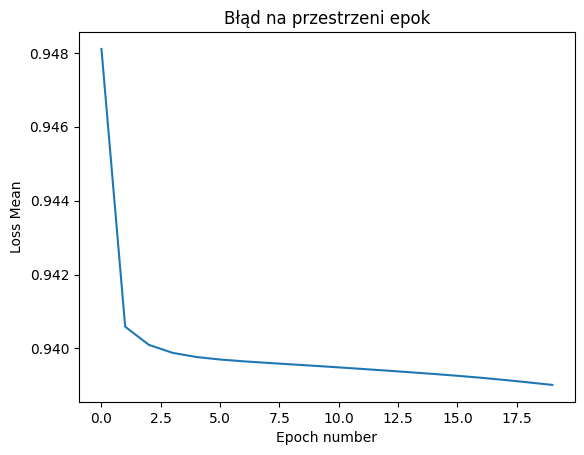

In [20]:
plt.plot(range(len(epochs_losses)), epochs_losses)

plt.xlabel("Epoch number")
plt.ylabel("Loss Mean")

plt.title("Błąd na przestrzeni epok")
plt.show()


# Walidacja przy założeniu, że model ma przewidzieć ostatnie 6 dni oraz 1 przyszły

In [21]:
model.eval()

results = []
with torch.no_grad():
    correct, all_ = 0, 0
    for X_s, X_p, labels in test_loader:

        X_s = X_s.unsqueeze(2).to(device)
        X_p = X_p.to(device)
        labels = labels.unsqueeze(2).to(device)

        preds = model(X_s, X_p)

        results.append(abs(preds-labels).mean())

print((sum(results)/len(results))*std+mean)


tensor(21.3414, device='cuda:0')


# Walidacja przy założeniu, że model ma przewidzieć 1 przyszły dzień

In [22]:
model.eval()

results = []
with torch.no_grad():
    correct, all_ = 0, 0
    for X_s, X_p, labels in test_loader:

        X_s = X_s.unsqueeze(2).to(device)
        X_p = X_p.to(device)
        labels = labels.unsqueeze(2).to(device)

        preds = model(X_s, X_p)

        results.append(abs(preds[-1]-labels[-1]).mean())

print(sum(results)/len(results)*std+mean)


tensor(21.3822, device='cuda:0')
